In [1]:
%load_ext autoreload
%autoreload 2


In [8]:
from flowField import *
from flowFieldWavy import *
import h5py
import numpy as np
import pdb
import cProfile
import time
from pseudo import *
from scipy.linalg import norm, svd
from scipy.sparse.linalg import gmres, LinearOperator
from scipy.optimize import newton_krylov,root,anderson
import exactRiblet as rib
import os
import resource

import matplotlib.pyplot as plt
%matplotlib inline

figureFolder = "/home/sabarish/Dropbox/reports/2016/equilibria/figures/"
docFolder = "./doc/figures/"
#%run test_flowFieldWavy.py
resnormFun = lambda x: x.slice(nd=[0,1,2]).residuals(pField=x.getScalar(nd=3)).appendField(x.slice(nd=[0,1,2]).div()).norm()

In [3]:
rib.testExactRibletModule(L=4,M=8,epsArr=np.array([0.,0.]),complexType=np.complex)
rib.testExactRibletModule(complexType=np.complex)

Success for both tests!
Success for both tests!


(True, True)

In [4]:
vf = h52ff('testFields/eq1.h5').slice(L=3,M=7)
pf = h52ff('testFields/pres_eq1.h5',pres=True).slice(L=4,M=7)
assert isinstance(vf,flowFieldRiblet) and isinstance(pf,flowFieldRiblet)

vf.flowDict['epsArr'] = np.array([0.,0.0])
pf.flowDict['epsArr'] = np.array([0.,0.0])
tol = 1.0e-06

In [6]:
x = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x.slice(L=3, M=5); x.flowDict['epsArr'] = np.array([0.,0.,0.01])
vf = x.slice(nd=[0,1,2]); pf = x.getScalar(nd=3)

#vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf,tol=1.0e-06,complexType=np.complex64)

# Symmetries of Eq1

In [5]:
x0 = loadh5('solutions/ribEq/L7M10/ribEq1L7M10N30E0000.hdf5')
x5 = loadh5('solutions/ribEq/L7M10/ribEq1L7M10N30E0500.hdf5')

def verifySyms(x, l0=None,l1=None, m0=None, m1=None, tol = 1.0e-09):
    L = x.nx//2; M = x.nz//2
    if l0 is None: l0 = -L
    if l1 is None: l1 = L
    if m0 is None: m0 = -M
    if m1 is None: m1 = M
    errFlag = 0
    for l in range(l0,l1):
        for m in range(m0,m1):
            # Verify symmetry in u,v:
            uvErr = np.linalg.norm( (x[0, L+l, M+m,:2] - ((-1.)**l) * x[0, L+l, M-m,:2]).flatten()  )
            if uvErr > tol: 
                errFlag = 1
                warn(
                "Symmetry $\\sigma_1$ is not satisfied by u and/or v mode (%d,%d). Error is %.3g"%(l,m,uvErr))
            # Verify symmetry in w:
            wErr = np.linalg.norm( (x[0, L+l, M+m,2] + ((-1.)**l) * x[0, L+l, M-m,2]).flatten()  )
            if wErr > tol: 
                errFlag = 1
                warn(
                "Symmetry $\\sigma_1$ is not satisfied by w for mode (%d,%d). Error is %.3g"%(l,m,wErr))
    if not errFlag:
        print("Symmetry $\\sigma_1$ is satisfied for all Fourier modes of x")

In [6]:
verifySyms(x0, tol=1.0e-10)

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:18: UserWarning: Symmetry $\sigma_1$ is not satisfied by u and/or v mode (0,-1). Error is 1.46e-10
/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:18: UserWarning: Symmetry $\sigma_1$ is not satisfied by u and/or v mode (0,1). Error is 1.46e-10


# Validating solver with laminar flows

In [9]:
flowDict = getDefaultDict()
flowDict.update({'L':1, 'M':6,'N':30,'alpha':5.,'beta':10.,'eps':0.05,'epsArr':np.array([0.,0.05]),'Re':100.,'isPois':0})

start = time.time()
for k in range(3):
    vf = flowFieldRiblet(flowDict=flowDict).view4d()
    vf[0,vf.nx//2,vf.nz//2,0] = vf.y
    pf = vf.getScalar().zero()

    vf, pf, fnorm, flg = rib.iterate(vf=vf, pf=pf,doLineSearch=False,rcond=1.0e-07)
print('runTime(s):',time.time()-start)
vf0 = vf.copy(); pf0 = pf.copy()

Initial residual norm is 0.0707
Starting iterations...............
iter: 1
Jacobian inversion success with residual norm  2.96800245451e-14
residual norm before setSymms: 1.47171199884e-13
Residual norm after setSymms in 1 th iteration is 1.47e-13
Converged in  1  iterations. Returning....................................
Initial residual norm is 0.0707
Starting iterations...............
iter: 1
Jacobian inversion success with residual norm  2.96800245451e-14
residual norm before setSymms: 1.47171199884e-13
Residual norm after setSymms in 1 th iteration is 1.47e-13
Converged in  1  iterations. Returning....................................
Initial residual norm is 0.0707
Starting iterations...............
iter: 1
Jacobian inversion success with residual norm  2.96800245451e-14
residual norm before setSymms: 1.47171199884e-13
Residual norm after setSymms in 1 th iteration is 1.47e-13
Converged in  1  iterations. Returning....................................
runTime(s): 174.1941900253296


0.0

# Low res EQ1

In [21]:
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')


In [35]:
x=x0.copy()
resnormFun = lambda x: x.slice(nd=[0,1,2]).residuals(pField=x.getScalar(nd=3)).appendField(x.slice(nd=[0,1,2]).div()).norm()

In [36]:
eArr = np.arange(0.,0.025001,0.001)
normArrE1 = np.zeros(eArr.size)
for k in range(eArr.size):
    eps1 = eArr[k]
    x= x0.copy()
    x.flowDict['epsArr'] = np.array([0.,eps1])
    x.flowDict['eps'] = eps1
    
    normArrE1[k] = resnormFun(x)

normArrE2 = np.zeros(eArr.size)
for k in range(eArr.size):
    eps = eArr[k]
    x= x0.copy()
    x.flowDict['epsArr'] = np.array([0.,0.0001,eps])
    x.flowDict['eps'] = 0.0001
    
    normArrE2[k] = resnormFun(x)

normArrE3 = np.zeros(eArr.size)
for k in range(eArr.size):
    eps = eArr[k]
    x= x0.copy()
    x.flowDict['epsArr'] = np.array([0.,0.0001,0.,eps])
    x.flowDict['eps'] = 0.0001
    
    normArrE3[k] = resnormFun(x)



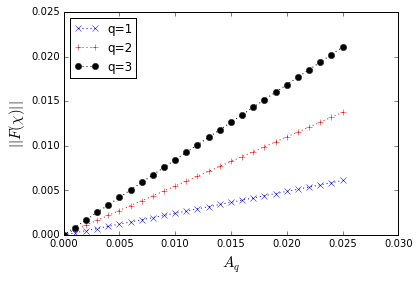

In [43]:
plt.figure()
plt.plot(eArr, normArrE1,'x:')
plt.plot(eArr, normArrE2,'r+:')
plt.plot(eArr, normArrE3,'ko:')
plt.xlabel("$A_q$",fontsize=15); plt.ylabel("$||F(\\chi)||$", fontsize=15)
plt.legend(["q=1","q=2","q=3"],loc=2)
#plt.yscale("log")
plt.show()

In [44]:
x = loadh5('solutions/e1/A01/tmp/ribEq1_0_L7M16N35E1_005.hdf5')

In [46]:
x.flowDict['eps'] = 0.; x.flowDict['epsArr'] = np.array([0.,0.])
resnormFun(x)

0.0012213303303876936

# Plots for JFMrapids

## Residual norms, accuracy, energy density, bulk dissipation rate

In [90]:
loadPath='solutions/e1/'
nSol = 21 # Number of solutions
x0 = loadh5('ribEq1L7M10N30E0000.hdf5').slice(L=7,M=16,N=35) # Initial iterate: Sol for flat-walled Couette

# Scalars to be plotted:
resnormArr = np.zeros(nSol)   # Residual norm of converged solutions
accArr = np.zeros(nSol)       # Accuracy of solutions w.r.t grid size
distArr = np.zeros(nSol)      # Distance from x0
energyArr = np.zeros(nSol)    # Energy density
dissipationArr = np.zeros(nSol) # Bulk dissipation rate
pInputArr = np.zeros(nSol)

resnormArr[0] = resnormFun(x0.slice(M=16,N=30))
accArr[0]  = resnormFun(x0.slice(L=14,M=20,N=60))
distArr[0] = 0.
energyArr[0] = x0.energy(); dissipationArr[0] = x0.dissipation(); pInputArr[0] = x0.powerInput()
for k in range(1,nSol):
    solPath = loadPath+'A%02d/'%(k)
    solName = 'ribEq1L7M16N35E1_%03d.hdf5'%(5*k)
    x = loadh5(solPath+solName)
    resnormArr[k] = resnormFun(x)
    accArr[k] = resnormFun(x.slice(L=14,M=32,N=70))
    distArr[k] = (x-x0).norm()
    
    energyArr[k] = x.energy()
    dissipationArr[k] = x.dissipation()
    pInputArr[k] = x.powerInput()
    

In [91]:
epsArr = np.arange(0.,0.1001,0.005)


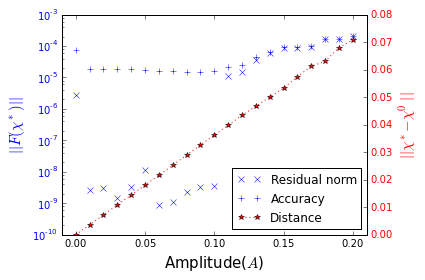

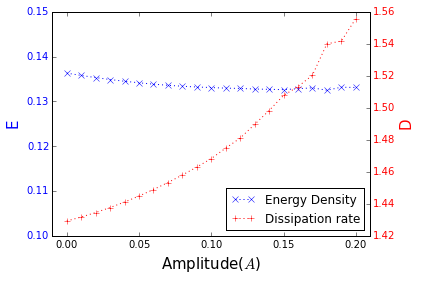

In [94]:
# Residual norm, accuracy, and distance
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, resnormArr,'bx',label='Residual norm')
ln2 = ax1.plot(2.*epsArr, accArr,'b+',label='Accuracy')
ax1.set_ylabel('$||F(\\chi^*)||$',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.21])
ax1.set_yscale('log')
#ax1.set_ylim([0.1,0.15])

ax2 = ax1.twinx()
ln3 = ax2.plot(2.*epsArr, distArr,'r*:',label='Distance')
ax2.set_xlim([-0.01,0.21])
ax2.set_ylabel('$||\chi^*-\chi^0||$',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=4)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'normDistE1.eps',format='eps',dpi=1200)
plt.show()





# Energy density and bulk dissipation rate
fig,ax1 = plt.subplots()
ln1 = ax1.plot(2.*epsArr, energyArr,'bx:',label='Energy Density')
ax1.set_ylabel('E',color='b',fontsize=15)
ax1.set_xlim([-0.01,0.21])
ax1.set_ylim([0.1,0.15])
ax2 = ax1.twinx()
ln2 = ax2.plot(2.*epsArr, dissipationArr,'r+:',label='Dissipation rate ')
ax2.set_xlim([-0.01,0.21])
ax2.set_ylabel('D',color='r',fontsize=15)

for tl in ax1.get_yticklabels():
    tl.set_color('b')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=4)

ax1.set_xlabel('Amplitude($A$)',fontsize=15)
plt.tight_layout()
plt.savefig(figureFolder+'energyDissipationE1.eps',format='eps',dpi=1200)
plt.show()


In [88]:
dissipationArr- pInputArr

array([ -2.96616728e-07,   6.83102978e-04,   2.74398629e-03,
         6.19428385e-03,   1.10379027e-02,   1.72709271e-02,
         2.48819655e-02,   3.38520103e-02,   4.41551090e-02,
         5.57587251e-02,   6.86242769e-02,   8.27161599e-02,
         9.79803396e-02,   1.14432063e-01,   1.32033310e-01,
         1.50691946e-01,   1.70097890e-01,   1.90614662e-01,
         2.12447720e-01,   2.34724059e-01,   2.58075986e-01])

## Phase-difference

In [29]:
# eps_1 = 0
x0 = loadh5('ribEq1L7M10N30E0000.hdf5')
x = x0
phaseArrZ = 2.*np.pi*np.arange(0.,1.001,0.05)

normArr = np.zeros(phaseArrZ.size)
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArr[m] = resnormFun(shiftPhase(x,phiZ=phiZ))
        
normArrA01 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e1/A01/ribEq1L7M16N35E1_005.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA01[m] = resnormFun(shiftPhase(x,phiZ=phiZ))
        
        
normArrA05 = np.zeros(phaseArrZ.size)
x = loadh5('solutions/e1/A05/ribEq1L7M16N35E1_025.hdf5')
for m in range(phaseArrZ.size):
    phiZ = phaseArrZ[m]
    normArrA05[m] = resnormFun(shiftPhase(x,phiZ=phiZ))
        



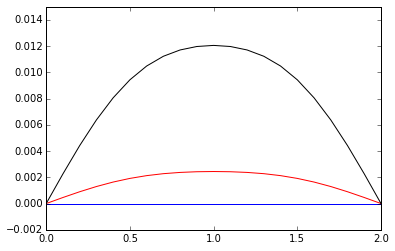

In [30]:
plt.plot(phaseArrZ/np.pi, normArr)
plt.plot(phaseArrZ/np.pi, normArrA01,'r')
plt.plot(phaseArrZ/np.pi, normArrA05,'k')
plt.ylim([-0.002,0.015])
#plt.yscale("log")
plt.show()

In [33]:
x1 = x.copy()
x1[:,:,:,:2] = -x1[:,:,:,:2,::-1]
x1[:,:,:,3] = -x1[:,:,:,3,::-1]
for phiX in (2.*np.pi*np.arange(0.,1.001,0.1)):
    print(phiX/np.pi,resnormFun(shiftPhase(x1,phiZ=np.pi,phiX=phiX)))

0.0 0.0679579759024
0.2 0.0679579759024
0.4 0.0679579759024
0.6 0.0679579759024
0.8 0.0679579759024
1.0 0.0679579759024
1.2 0.0679579759024
1.4 0.0679579759024
1.6 0.0679579759024
1.8 0.0679579759024
2.0 0.0679579759024
